<a href="https://colab.research.google.com/github/baoquan25/bot_trading_stock/blob/main/Bot_Trading_ch%E1%BB%A9ng_kho%C3%A1n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
frt = pd.read_csv('/content/drive/MyDrive/FRT.csv')

In [ ]:
frt.drop(columns=["% Thay đổi"], inplace= True)

In [ ]:
#định dạng cấu trúc thời gian
frt['Ngày'] = pd.to_datetime(frt['Ngày'],format="%d/%m/%Y")

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Sắp xếp lại dữ liệu theo thứ tự thời gian
frt=frt.sort_values(by='Ngày')


In [ ]:
# chuyển đổi định dạng cột giá thành số thực
frt['Lần cuối'] = frt['Lần cuối'].str.replace(',', '').astype(float)
frt['Mở'] = frt['Mở'].str.replace(',', '').astype(float)
frt['Cao'] = frt['Cao'].str.replace(',', '').astype(float)
frt['Thấp'] = frt['Thấp'].str.replace(',', '').astype(float)

In [ ]:
# Lấy thông tin năm từ cột "Ngày"
frt['năm'] = frt['Ngày'].dt.year

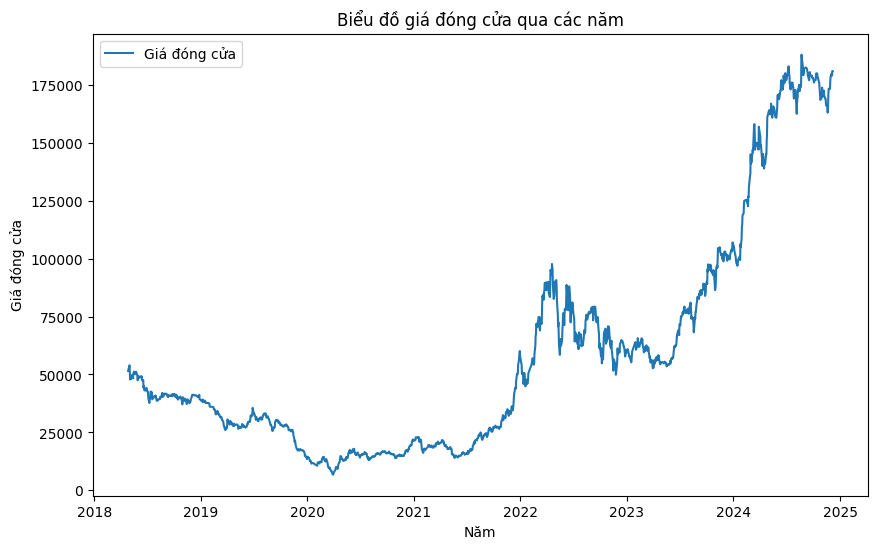

In [ ]:
# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 6))
plt.plot(frt['Ngày'],frt['Lần cuối'], label='Giá đóng cửa')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa qua các năm')
plt.legend()

In [ ]:
frt.rename(columns={'Lần cuối': 'Đóng cửa'}, inplace=True)

In [ ]:
frt1 = pd.DataFrame(frt,columns=['Ngày','Đóng cửa'])
frt1.index = frt1['Ngày']
frt1.drop('Ngày',axis=1,inplace=True)
frt1

,Đóng cửa
Ngày,
2018-04-27,51516.3
2018-05-02,53923.6
2018-05-03,50392.9
2018-05-04,47825.1
2018-05-07,48788.0
...,...
2024-12-02,179800.0
2024-12-03,179600.0
2024-12-04,179000.0


In [ ]:
#chia tập dữ liệu
data = frt1.values
train_data = data[:1300]
test_data = data[1300:]

In [ ]:
#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)
sc_train

array([[0.24713975],
       [0.26041871],
       [0.24094295],
       ...,
       [0.95035493],
       [0.96138717],
       [0.96083556]])

In [ ]:
#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) # Dự đoán giá trị 'close' (cột đầu tiên)

In [ ]:
x_train

In [ ]:
y_train

In [ ]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [ ]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#lớp 1 LSTM
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(Dropout(0.2)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)

#Lớp 2 LSTM
model.add(LSTM(units=64))
model.add(Dropout(0.2)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)

model.add(Dense(1)) #output đầu ra 1 chiều

#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/model1.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.00952, saving model to /content/drive/MyDrive/model1.keras
25/25 - 5s - 211ms/step - loss: 0.0095
Epoch 2/100

Epoch 2: loss improved from 0.00952 to 0.00900, saving model to /content/drive/MyDrive/model1.keras
25/25 - 8s - 311ms/step - loss: 0.0090
Epoch 3/100

Epoch 3: loss improved from 0.00900 to 0.00836, saving model to /content/drive/MyDrive/model1.keras
25/25 - 6s - 248ms/step - loss: 0.0084
Epoch 4/100

Epoch 4: loss did not improve from 0.00836
25/25 - 4s - 154ms/step - loss: 0.0092
Epoch 5/100

Epoch 5: loss did not improve from 0.00836
25/25 - 6s - 224ms/step - loss: 0.0092
Epoch 6/100

Epoch 6: loss did not improve from 0.00836
25/25 - 5s - 195ms/step - loss: 0.0086
Epoch 7/100

Epoch 7: loss did not improve from 0.00836
25/25 - 3s - 124ms/step - loss: 0.0094
Epoch 8/100

Epoch 8: loss did not improve from 0.00836
25/25 - 9s - 355ms/step - loss: 0.0089
Epoch 9/100

Epoch 9: loss did not improve from 0.00836
25/25 - 8s - 309m

In [ ]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/model1.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


In [ ]:
#xử lý dữ liệu test
test = frt1[len(train_data)-50:].values
test = test.reshape(-1,1)

# Loại bỏ các hàng chứa NaT trong test trước khi áp dụng transform
# Thay thế np.isnan bằng pd.isnull để xử lý các kiểu dữ liệu khác, bao gồm cả NaT
test = test[~pd.isnull(test).any(axis=1)]

sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1300:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


<ipython-input-21-64e662c5d10b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
<ipython-input-21-64e662c5d10b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu


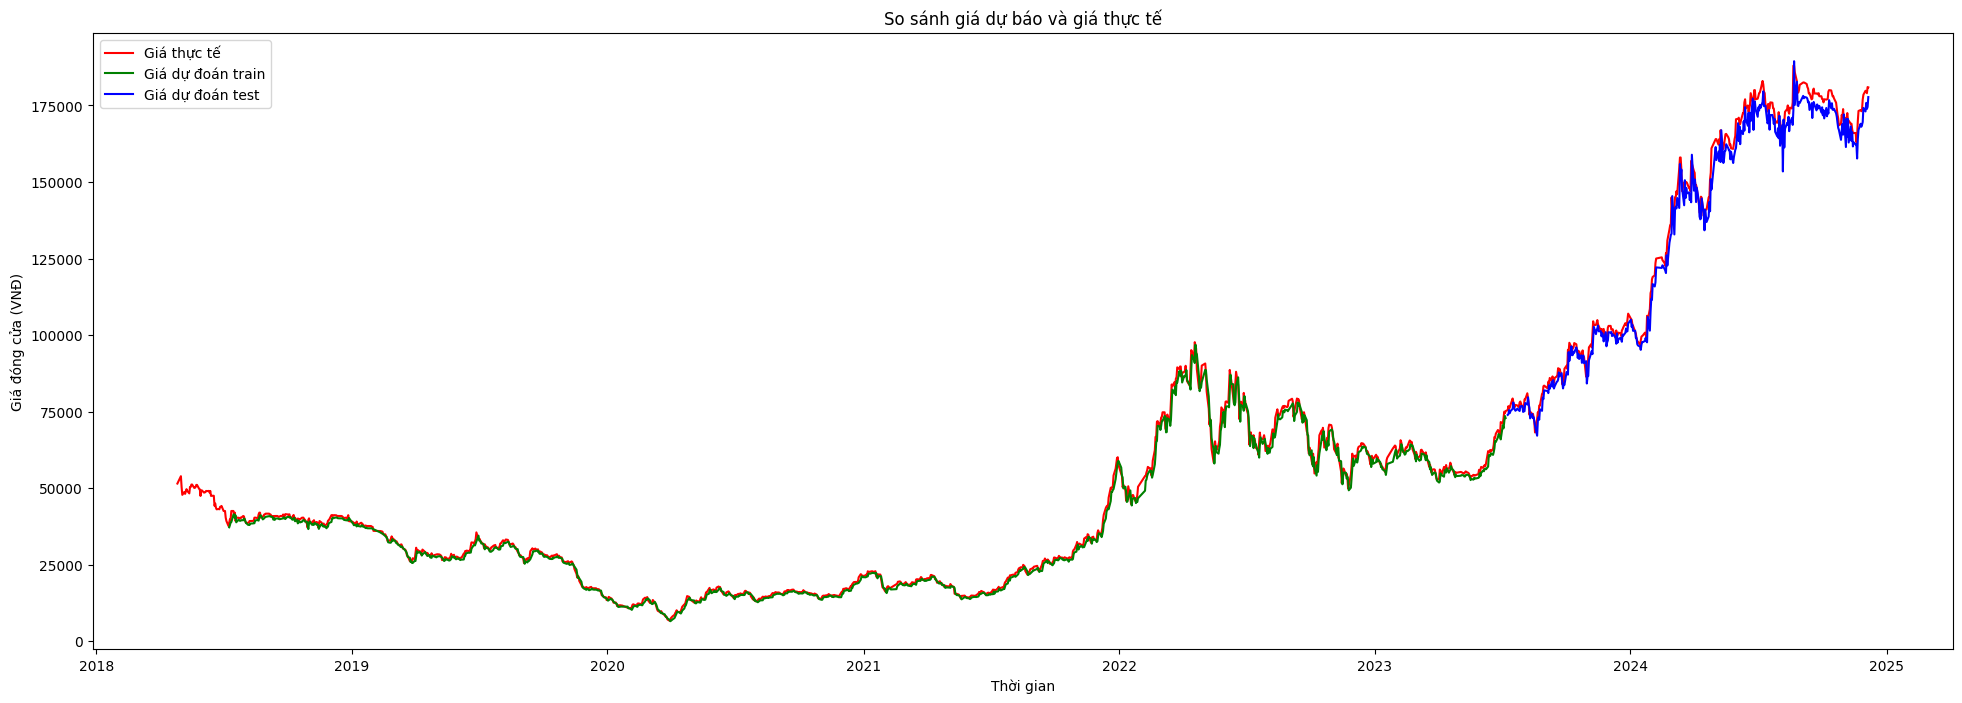

In [ ]:
#lập biểu đồ so sánh
train_data1 = frt1[50:1300]
test_data1 = frt1[1300:]

plt.figure(figsize=(24,8))
plt.plot(frt1,label='Giá thực tế', color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


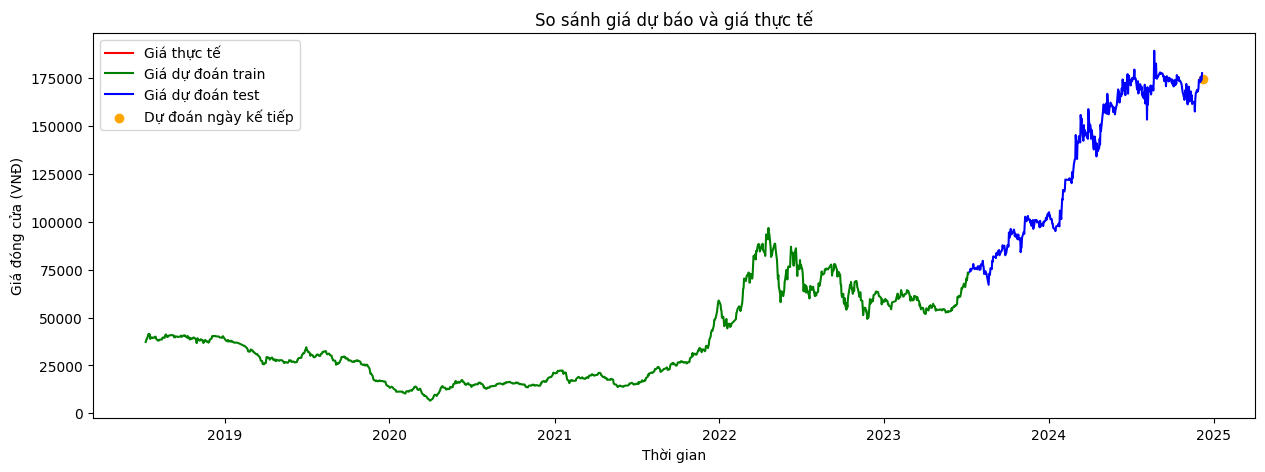

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = frt['Ngày'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([frt['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
frt_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
frt1 = pd.concat([frt1, frt_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(frt1['Ngày'], frt1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

In [ ]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = frt['Đóng cửa'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_frt = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_frt)

        Ngày  Giá dự đoán  Giá ngày trước
0 2024-12-07  174874.0625        180900.0


In [ ]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))


Độ phù hợp tập test: 0.9871755249026515
Sai số tuyệt đối trung bình trên tập test (VNĐ): 3506.973292661517
Phần trăm sai số tuyệt đối trung bình tập test: 0.02544602923003724


In [ ]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9942784626125748
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1121.233493515624
Phần trăm sai số tuyệt đối trung bình tập train: 0.030991127865378616
